# Tutorial on processing and analyzing PAX polarization datasets

<font color='red'>Updated: 2024/06/17

<font color='red'>Author: Evan McClintock

## Introduction

To fully characterize the PTF of a fiber optic cable at any point in time (call it $R_C(t)$), one must measure the effect of $R_C$ on *two* linearly independent input SOPs: $V_{1,out} = R_C V_{1,in}$ and $V_{2,out} = R_C V_{2,in}$. The two input states $V_{1,in}$ and $V_{2,in}$ are rapidly alternated in time and transmitted through the DUT. The PAX polarimeter measures $V_{1,out}$ and $V_{2,out}$ as they are alternated in time.

It was observed that the PAX has an extremely poor and inconsistent measurement rate; [this](www.google.com) github repositiory provides a few quick tools (also included here) to characterize variability in the Time Between Samples (TBS) in any PAX dataset. This variability makes it impossible to systematically separate the two output SOPs in time by the number of samples taken. It also seemed highly difficult to synchronize the clock of the waveform generator with that of the PAX (not to mention the variability in the frequency of the generated waveform), so we opted for a programmatic approach to automatically identify the time-alternating behavior and separate the output SOPs for further analysis.

The functions of this github repository are to:
1. Automatically identify the change-points (a.k.a. "switches") between the two SOPs and perform initial processing of the measurement data.
2. Provide tools for subsequent SOP visualization and analysis.

## Overview

Processing a PAX dataset consists of four steps:
1. Read in the raw data
2. Identify the switches (change points)
3. Separate the SOPs and average the data within each segment
4. Calculate drift in the PTF

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib tk
#%matplotlib inline
import pandas as pd
#from datetime import timedelta
import allantools #https://allantools.readthedocs.io/en/latest/functions.html
import os
import scipy.stats as ss
import pickle
#import copy
#import math
#import time
#import seaborn as sns
#import warnings
BOLD_ON = "\033[1m"
BOLD_OFF = "\033[0m"

In [2]:
# Import data analysis code
import importlib
import data_manager
importlib.reload(data_manager)
from data_manager.dataset import Dataset
from data_manager.stationary import StationarySet
from data_manager.switch import SwitchSet
import data_manager.utils.plotting_utils as P
from data_manager.utils.hourly_dividing_utils import Divider
from data_manager.pairs import IOPair

In [3]:
# Directory information
LAB = "/mnt/c/Users/2020n/Documents/Career/Locations/Britton Lab/"   # Path to lab folder
DATA = LAB + "QWDM_Project/H1_Datasets/"   # Path to folder of datasets

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/evanshaped/anaconda3/envs/britton2024envWSL/bin/python
3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)


## Initialization

### Read in raw data; preprocess

**`class SwitchSet(filename, set_range=None, skip_default_signal_baseline=0.0)`**
> Stores and processes data from the PAX1000 polarimeter. Upon initializing a SwitchSet instance, data from the PAX csv file is cleaned. See the PAX [manual](https://www.manualslib.com/manual/1634678/Thorlabs-Pax1000.html?page=39#manual) for details on the recorded quantities.

**Parameters**
- **filename:** ***String***\
  The name of the file to be processed, including the file extension. Example: `filename="/path/to/folder/name_of_file.csv"

- **set_range:** ***Tuple[float, float], optional***\
  The range of data to read. Default is None (read all avaliable data). Use tuple of two floats to specify the percentage of data to read (reading the entirety of large datasets takes a long time). For example, set_range=(0.05,0.1) specifies the chunk of the dataset between 5% and 10%.

- **skip_default_signal_baseline:** ***float, optional***\
  How many seconds of data from the beginning of the dataset to discard.

Initialize a `SwitchSet` object with the csv file and information on how much data to read. Below, we read in the first 2% of this dataset using `set_range=(0,0.02)`. We set `skip_default_signal_baseline=0.0` so we don't skip any of the initial data.

In [5]:
# Read in raw dataset
filename = DATA + 'Whole_setup/24-03-13/PAX_3-13_ARL_Orth_2_1345_desktop.csv'
ds_1345 = SwitchSet(filename, set_range=(0,0.02), skip_default_signal_baseline=0.0)

Time range: min=0.1, max=839.536


### Print dataset information

**`SwitchSet.print_info()`**
> Print the metainformation obtained from the csv file (PAX configuration and basic dataset info).

First, lets print the metainformation obtained from the header of the csv file and some information about the dataset after processing. Note the discrepancy between the nominal sample rate (200Hz) and the (average) sample rate actually recorded (52Hz).

In [6]:
ds_1345.print_info()

=== PAX Configuration parameters ===
Device ID: PAX1000IR2
Serial number: M00572108
Wavelength (nm): 1345.00
Basic Sample Rate (Hz): 400.0
Operating Mode Period (# of rotations): 1.0
Operating Mode FFT Points: 1024
--> Nominal Sample Rate (Hz): 200.00

=== Dataset information ===
Filename: /mnt/c/Users/2020n/Documents/Career/Locations/Britton Lab/QWDM_Project/H1_Datasets/Whole_setup/24-03-13/PAX_3-13_ARL_Orth_2_1345_desktop.csv
Time range read (seconds): min=0.10, max=839.54
Average Sample Rate (Hz): 52.35


### Plot raw data

**`SwitchSet.plot_raw(plot_param='s1', sample_range=None, birds_eye=True)`**
> Plots the raw data over the given range of time, with the option to show the results of processing steps.

**Parameters**
- **plot_param:** ***String, default: 's1'***\
  Which parameter to plot. See the PAX [manual](https://www.manualslib.com/manual/1634678/Thorlabs-Pax1000.html?page=39#manual) for details on the recorded quantities. Options are:
  * 's1', 's2', 's3' - Normalized stokes parameters (unitless)
  * 'S0', 'S1', 'S2', 'S3' - Unnormalized stokes parameters (in mW)
  * 'Azimuth', 'Ellipticity' - Polarization ellipse angles (in degrees)
  * 'DOP', 'DOCP', 'DOLP' - Degree of polarization, degree of circular polarization, degree of linear polarization (all in %)
  * 'Power', 'Power_pol', 'Power_unpol' - Total power, polarized power, unpolarized power (all in mW)
  * 'Power_split_ratio' - See PAX manual (unitless)
  * 'Phase_difference' - See PAX manual (unitless)
<br><br>
- **sample_range:** ***Tuple[float, float], optional***\
  If provided, plots a zoomed in view of the dataset around the time range given (i.e., `sample_range=(15,20)` plots from t = 15 seconds to t = 20 seconds). By default, the zoomed in view is not plotted

- **birds_eye:** ***bool, default: True***\
  Whether to plot the "birds eye" view (the entirety) of the dataset.

- **plot_switch:** ***bool, default: False***\
  Only has an effect after `SwitchSet.find_switches(...)` has been run. Plots the detected switch jumps, and estimated switch times. Samples that are kept for analysis are plotted in blue, while samples that were discarded (for risk of being too close to the switch times and mis-measured) remain plotted in red.

- **plot_avg:** ***bool, default: False***\
  Only has an effect after `SwitchSet.average_data(...)` has been run. Once each 'segment' of valid data is identified and averaged, the averaged point for each segment is plotted.

Now we examine what the dataset looks like. Using `SwitchSet.plot_raw(...)`, we plot a birds-eye view of the dataset, and a view zoomed in on the first few seconds. Change around the `sample_range` parameter to explore different parts of the dataset.

By default, the first normalized stokes parameter (s1) is plotted, but we can change this using `plot_param='s2'` or `plot_param='power'`, for example.

Note the title of each plot: **plotted parameter | dataset title | range of time shown in this plot**

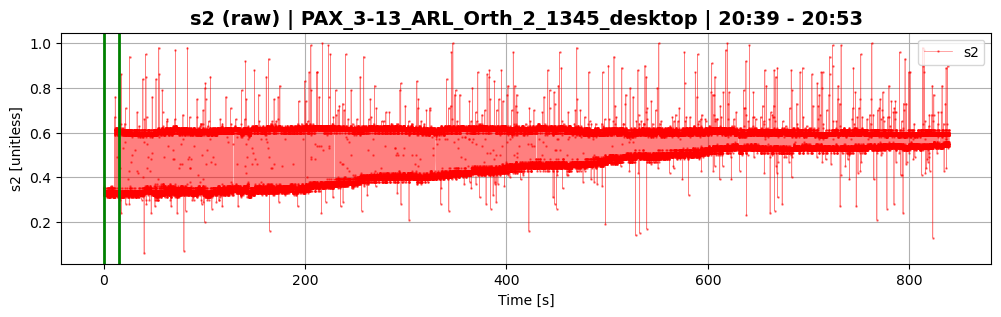

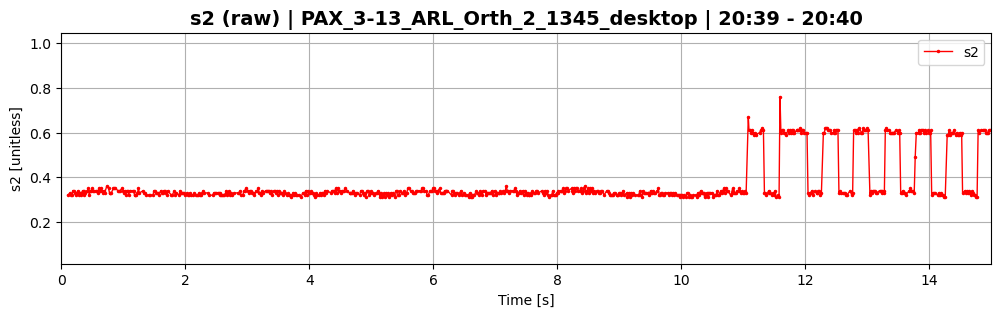

In [7]:
# Plot example section
ds_1345.plot_raw(plot_param='s2', sample_range=(0, 15), birds_eye=True)

### Adjust dataset initialization

We see that the first ~12 or so seconds were used to let the default SOP run by itself and to synchronize the OMSs. Now that we know what the data looks like, we can re-instantiate the `SwitchSet` object with more data and ignore the first few seconds where the experiment was being initialized. We'll read in 10% of the data this time, and skip the first 15 seconds.

In [8]:
ds_1345 = SwitchSet(filename, set_range=(0,0.1), skip_default_signal_baseline=15)

Time range: min=15.026, max=4162.506


### Plot histogram of TBS (time between samples)

**`SwitchSet.plot_tbs_hist(log=True, bins=50, xmax=None)`**
> Plots the times between recorded samples (TBS) to visualize how (in)consistent the PAX was when taking data.

**Parameters**
- **log:** ***bool, default: True***\
  Whether to make the y-axis log-scale. A log scale highlights the outliers in teh TBS, but may give the viewer a skewed understanding of how poor the PAX performs.

- **bins:** ***int, default: 50***\
  Bins for the histogram.

- **xmax:** ***float, optional***\
  Manually sets the maximum value for the xaxis. Useful to decrease if there is one very large lag that compresses the rest of the data.

We may also examine how varied the recording time between adjacent samples is. Occasionally there are exceptionally long (second-long) lags in recording time. [This](https://github.com/evanshaped/PAX-rate-visualization) github repo goes into more detail.

This was observed to be common behavior for the PAX when recording every sample. The behavior necessitates special code to identify the switch times between SOP signals.

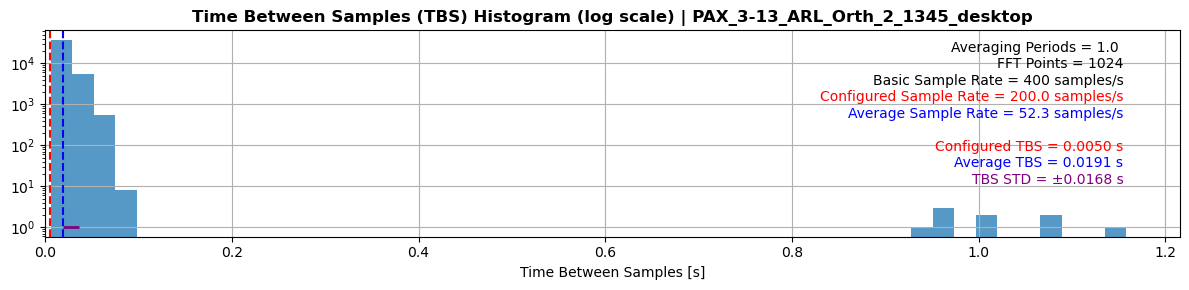

In [8]:
ds_1345.plot_tbs_hist(log=True, bins=50, xmax=None);

## Processing

### Locate switch times

**`SwitchSet.find_switches(nominal_switch_rate=2, print_process=False)`**
> The OMS regularly switches between SOP signals, but the Time Between Samples (TBS) is highly inconsistent when being recorded by the PAX. This function automatically identifies the jumps between the two SOP signals within a 100-second-long portion of data, and infers the offset of the switch times for the rest of the dataset.

> The waveform generator has a numerical precision limit. Often the wave is off from 2Hz by a fraction of a percent, and this difference builds up over time. For long (multi-hour) datasets, `SwitchSet.find_switches` has the additional job of calculating and applying this difference.

**Parameters**
- **nominal_switch_rate:** ***float, default: 2.0***\
  The frequency of the square wave (in Hz) provided to the OMS

- **print_process:** ***bool, default: False***\
  Whether to print info on switch identification. Used for debugging.

Provide `nominal_switch_rate` to the function (the rate, in Hz, with which the OMS alternates between transmitting SOPs); the rest will be done automatically. Note that *the program assumes that the first few seconds of initialization data (often ~15) was skipped when creating the dataset.*

In [9]:
ds_1345.find_switches(nominal_switch_rate=2)

After `SwitchSet.find_switches(...)` has been run, plotting displays some information about the detected switches.
* Vertical purple lines mark the estimated switch times.
* Samples that are kept for analysis are plotted in blue, while samples that were discarded (for risk of being too close to the switch times and mis-measured) remain plotted in red.

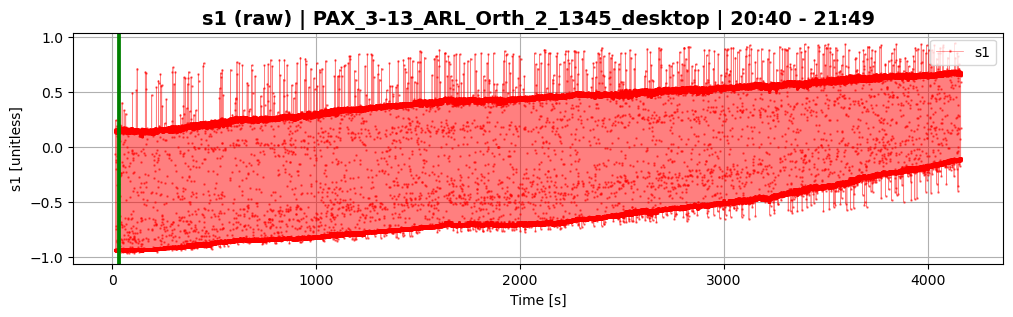

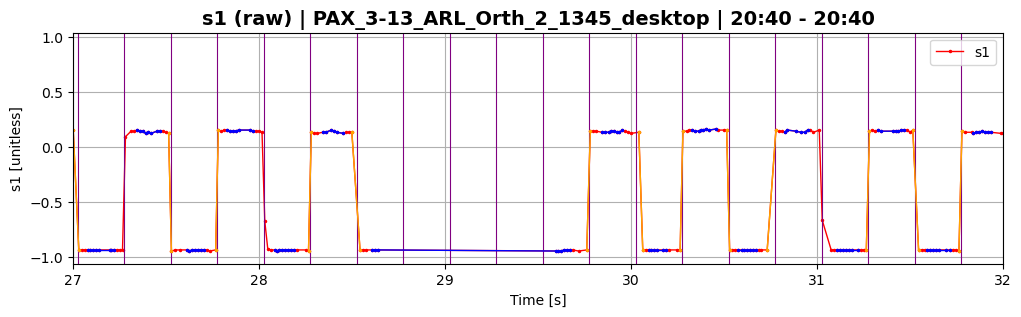

In [10]:
ds_1345.plot_raw(sample_range=(27,32), birds_eye=True)

### Average data

**`SwitchSet.average_data(print_process=False, print_assignment=False)`**
> Assumes `SwitchSet.find_switches(...)` has already been run.

> Within each SOP 'segment' (denoted by two adjacent purple switch lines), the valid samples (shown in blue) are averaged to a single point. This creates a series of evenly spaced points. Every other point is part of one SOP signal, and is linked together.

> Where there are too many missing values (sparse but not uncommon), linear interpolation is used to fill the gaps. (See [this](www.google.com) page for how manual interpolation affects an Allan Deviation analysis).

**Parameters**
- **print_process:** ***bool, default: False***\
  Prints information on the averaging, interpolation, and assignment of SOP signals. Used for debugging.

In [11]:
ds_1345.average_data(print_process=False)

After `SwitchSet.average_data(...)` has been run, plotting displays the averaged points overtop the raw data.

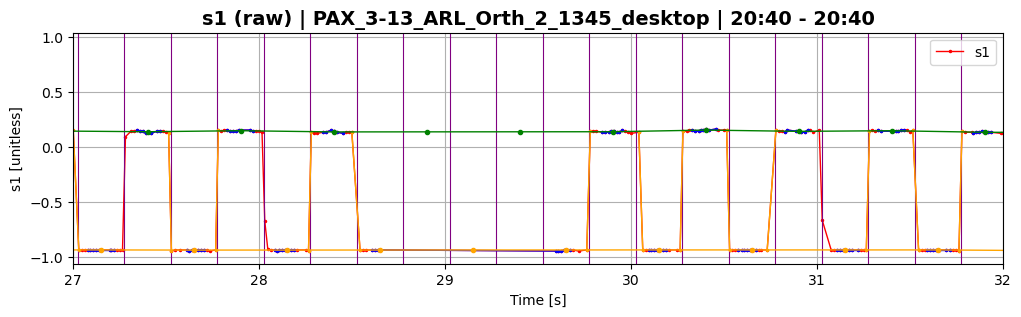

can't invoke "event" command: application has been destroyed
    while executing
"event generate $w <<ThemeChanged>>"
    (procedure "ttk::ThemeChanged" line 6)
    invoked from within
"ttk::ThemeChanged"


In [12]:
ds_1345.plot_raw(sample_range=(27,32), birds_eye=False)

We may now choose to plot just the separated and averaged data (the data used for further processing).

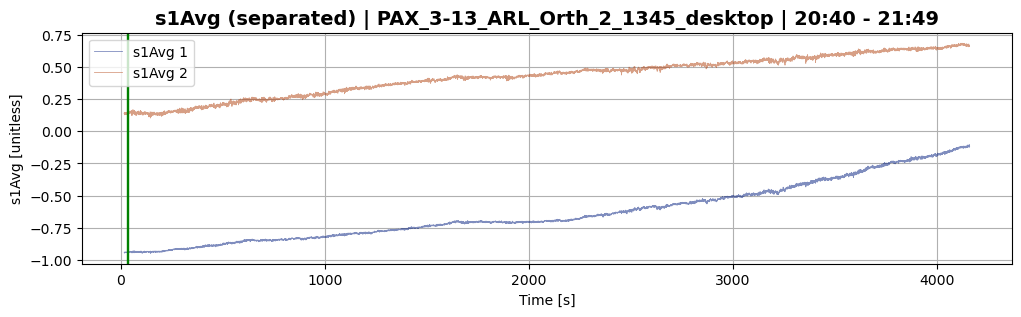

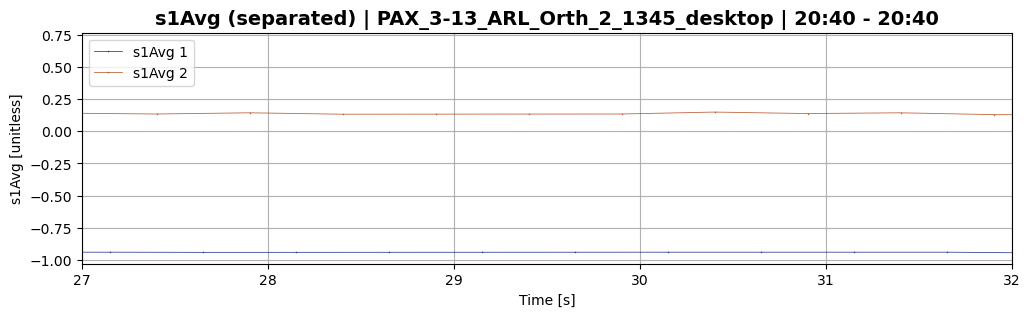

In [13]:
ds_1345.plot_separated(plot_param='s1Avg', sample_range=(27,32))

## Calcuate PTF drift

Having measured two input/output SOP pairs $(V_{1,in},V_{1,out})$ and $(V_{2,in},V_{2,out})$, we may calculate the PTF $R_C(t)$ of the fiber optic at the time $t$ the output SOPs were measured. (We assume that the time difference between measuing $V_{1,out}$ and $V_{2,out}$ is small enough that the PTF has not changed significantly).

Imagine Alice (transmitting) and Bob (receiving) convene to calculate $R_C(t_0)$ at time $t_0$. They return to their experiment. At time $t$, when the PTF is now $R_C(t)$, Alice transmits SOP $V_A$ while Bob measures $V_B(t) = R_C(t) V_A$. However, Bob tries to reverse engineer $V_A$ using outdated information: the PTF at time $t_0$. He calculates $V_A'(t) = R^{-1}_C(t_0) V_B(t)$, which is different than the actual input SOP $V_A = R^{-1}_C(t) V_B(t)$.

We may calculate a measure of "error", $\theta$, the angle between the calculated input SOP $V_A'(t)$ and the actual input SOP $V_A$. Given the PTF $R_C(t)$ and some reference time $t_0$, we define $\theta_D(t)$, the maximum possible discrepancy between the actual SOP $V_A$ that Alice transmits and the estimated SOP $V_A'(t)$ that Bob calculates using $R_C(t_0)$. See section 6 of the PHYS407 [writeup](https://drive.google.com/file/d/1BhQE3h3j9Iu7FBE2fxYRr2jE6YrFzR7w/view?usp=drive_link) for details on how this metric is defined and calculated.

This is a 1-dimensional metric for PTF drift, and in our experiment where we continuously measure the output SOPs $V_{1,out}$ and $V_{2,out}$, it may be calculated without actually knowing the input SOPs $V_{1,in}$ and $V_{2,in}$ (see the writeup for details, but basically all we care about is the drift in the PTF, so the input SOPs cancel out in the math). The function `SwitchSet.calc_stokes_ptf(...)` calculates the drift metric $\theta_D(t)$ only using the output SOPs $V_{1,out}$ and $V_{2,out}$ and some reference time $t_0$.

**`SwitchSet.calc_stokes_ptf(reference=None, angle_threshold_deg=10, reset_delay=0, reset_by_rolling=True, rolling_pts=5, print_process=False)`**
> This function calculates $\theta_D(t)$, the "drift" in the PTF of the fiber. See section 6 of the PHYS407 [writeup](https://drive.google.com/file/d/1BhQE3h3j9Iu7FBE2fxYRr2jE6YrFzR7w/view?usp=drive_link) for details. $\theta_D(t)$ may be calculated only using the measured output SOPs $V_{1,out}$ and $V_{2,out}$, and a reference time $t_0$.

> This function also has the task of *resetting* the reference time when $\theta_D(t)$ exceeds some threshold or after some amount of time, mirroring the process an actual TDM experiment might use to continuously re-characterize $R_C$ as it drifts.

**Parameters**
- **reference:** ***bool, default: False***\
  Prints information on the averaging, interpolation, and assignment of SOP signals. Used for debugging.

- **angle_threshold_deg:** ***bool, default: False***\
  Prints information on the averaging, interpolation, and assignment of SOP signals. Used for debugging.

- **reset_delay:** ***bool, default: False***\
  Prints information on the averaging, interpolation, and assignment of SOP signals. Used for debugging.

- **reset_by_rolling:** ***bool, default: False***\
  Prints information on the averaging, interpolation, and assignment of SOP signals. Used for debugging.

- **rolling_pts:** ***bool, default: False***\
  Prints information on the averaging, interpolation, and assignment of SOP signals. Used for debugging.

- **print_process:** ***bool, default: False***\
  Prints information on PTF calculation and resetting the reference time. Used for debugging.

In [13]:
reset_times_1345 = ds_1345.calc_stokes_ptf(reference=None, angle_threshold_deg=5, reset_by_rolling=True, rolling_pts=5, print_process=True);

Using "resetting reference SOPs" approach with threshold = 5.0 degrees
Averaging rotAngle using 5 rolling points
Reference matrix was reset 2 times
Reset at time t=283.03
Reset at time t=499.03


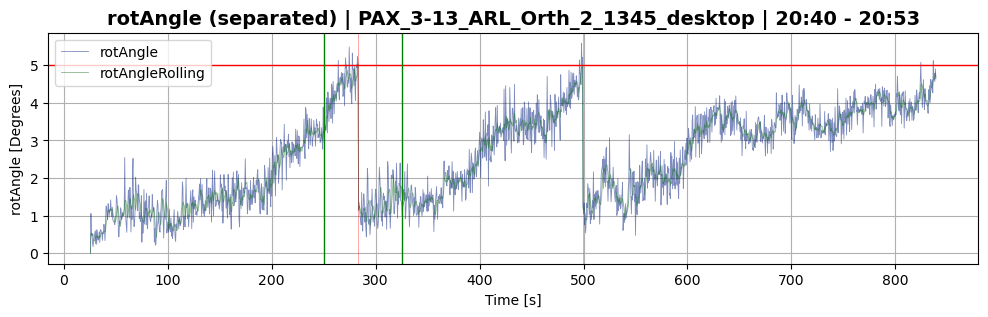

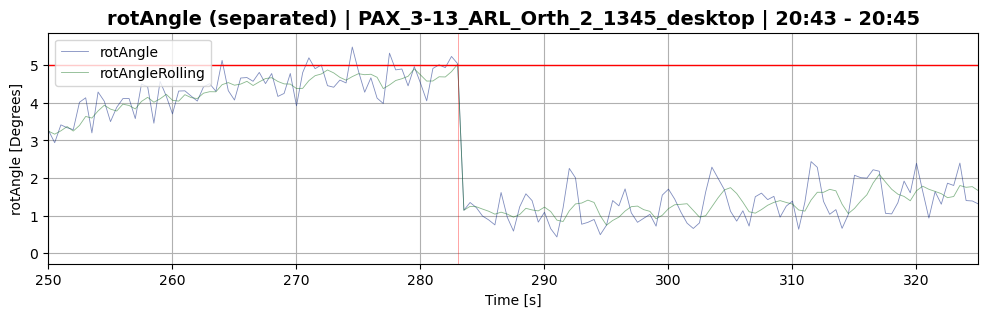

In [14]:
ds_1345.plot_separated(plot_param='rotAngle', sample_range=(250,325))

In [18]:
div = Divider(ds_1345)
params_arr = div.calc_adev_divided()

In [19]:
div.segment_dict

{}

In [17]:
params_arr

[]

In [ ]:
P.plot_adev(params_arr)